# Microbiome Data Analysis

In [136]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import statistics

## Species abundance distribution (SAD)

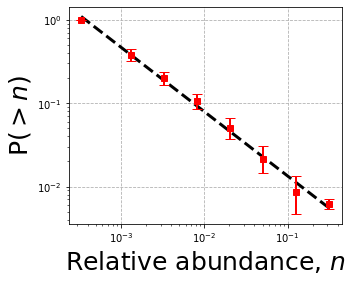

α = 0.77


In [137]:
# Load data
df = pd.read_csv('/Users/rie_maskawa/Dropbox/study/whole_life_mouse/data/mouse1.over0.1.csv', index_col=0).fillna(0)/3000

# Set parameters
max_read = 3000
cut_off = 1/2
num_bins = 9
ablog_lin = np.linspace(np.log10(1/max_read), np.log10(cut_off), num = num_bins)  # Log scale for abundance bins
ablog = 10 ** ablog_lin  # Convert to linear scale
prob_list = [[] for _ in range(num_bins)]  # Initialize a list to hold probabilities for each bin

# Process the data
for t in df.columns:
    OTU = df[t].values  # Get the abundance values
    OTU_nonzero = sorted(OTU[OTU != 0])  # Sort and remove zeros
    N = len(OTU_nonzero)
    prob = np.linspace(1/N, 1, N)[::-1]  # Probability distribution

    OTU_uniq, indices = np.unique(OTU_nonzero, return_index=True)
    prob_uniq = np.array(prob)[indices]
    prob_list[0].extend([1])

    # Distribute probabilities into bins based on abundance ranges
    for i in range(1, num_bins-1):
        prob_i = prob_uniq[(ablog[i]<=OTU_uniq) & (OTU_uniq<ablog[i+1])]
        if len(prob_i) > 0:
            prob_list[i].extend(prob_i)

    # Calculate quantiles for each bin (25th, 50th, and 75th percentiles)
    q = np.array([np.quantile(prob_list[i], [0.25, 0.5, 0.75]) if len(prob_list[i]) != 0 else [np.nan] * 3 for i in range(num_bins-1)])
    q1, q2, q3 = q[:, 0], q[:, 1], q[:, 2]

# Prepare x-axis values (log scale for bins)
x = np.array([ablog[0]] + list(10 ** ((ablog_lin[:-1] + ablog_lin[1:]) / 2)[1:]))

# Plot the results
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect("equal")

# Fit a line to the quantile data (log-log regression)
alpha, b = np.polyfit(np.log10(x[~np.isnan(q2)]), np.log10(q2[~np.isnan(q2)]), 1)
pred = 10 ** (alpha * np.log10(x) + b)  # Predicted line based on the regression
ax.plot(x, pred, 'k--', lw=3)  # Plot the fitted line

# Plot error bars (quantiles as uncertainty)
ax.errorbar(x, q2, yerr=[q2-q1, q3-q2], fmt='s', markersize=6, color='red', capsize=5, linewidth=2)

# Set axis labels
ax.set_xlabel(r'Relative abundance, $n$', fontsize=25)
ax.set_ylabel(r'P($>n$)', fontsize=25)
ax.grid(True, ls = '--')

# Show plot
plt.show()

print(f'α = {round(-alpha, 2)}')


## Taylor's law

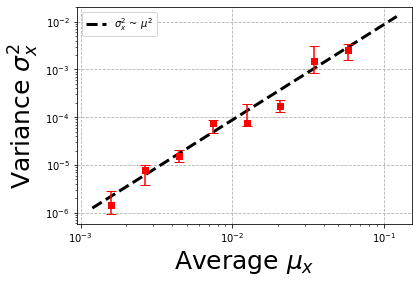

β = 1.87


In [138]:
# Load data
df = pd.read_csv('/Users/rie_maskawa/Dropbox/study/whole_life_mouse/data/mouse1.over0.1.csv', index_col=0).fillna(0)/3000

# Frequency threshold for filtering
threshold_freq = 0.8
num_bins = 10

# Prepare lists for average and standard deviation values
avg, std = [], []

# Convert dataframe to numpy array
raw_data = np.array(df)
num_samples = raw_data.shape[1]

# Apply frequency-based filtering
valid_rows = (np.where(raw_data > 0, 1, 0).sum(axis=1) / num_samples >= threshold_freq)
filtered_data = raw_data[valid_rows, :]
avg_raw = np.mean(filtered_data, axis=1)
std_raw = np.var(filtered_data, axis=1, ddof=0)

# Filter out zero values
avg_raw, std_raw = avg_raw[avg_raw != 0], std_raw[avg_raw != 0]

avg.extend(avg_raw)
std.extend(std_raw)

# Define log-scale bins
log_bins = np.logspace(np.log10(np.min(avg)), np.log10(np.max(avg)), num_bins)

# Calculate median and percentiles within each bin
medians, bin_centers, percentiles = [], [], []
for i in range(len(log_bins) - 1):
    bin_mask = (log_bins[i] < avg_raw) & (avg_raw <= log_bins[i + 1])
    bin_std = std_raw[bin_mask]
    if len(bin_std) > 0:
        medians.append(statistics.median(bin_std))
        bin_centers.append((log_bins[i] + log_bins[i + 1]) / 2)
        percentiles.append(np.percentile(bin_std, q=[0, 25, 50, 75, 100]))

percentiles = np.array(percentiles)
q1, q2, q3 = percentiles[:, 1], percentiles[:, 2], percentiles[:, 3]

# Create log-scaled x-axis and perform linear regression
log_x = np.logspace(np.log10(min(avg)), np.log10(max(avg)), num=num_bins)
cf = np.polyfit(np.log10(avg), np.log10(std), 1)
intercept = np.mean(np.log10(std) - 2 * np.log10(avg))
predicted_y = 10**intercept * log_x**2

# Plot results
fig, ax = plt.subplots()
ax.plot(log_x, predicted_y, 'k--', label=r'$\sigma_{x}^2$ ~ $\mu^2$', lw=3)
ax.plot(bin_centers, medians, 'rs', markersize=6, lw=0)
ax.errorbar(bin_centers, q2, yerr=[q2 - q1, q3 - q2], fmt='s', markersize=6, capsize=5, color='red')

# Set log scales and labels
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Average $\mu_x$', fontsize=25)
ax.set_ylabel(r'Variance $\sigma_x^2$', fontsize=25)
ax.grid(True, ls = '--')
ax.legend()

plt.show()

print(f'β = {round(cf[0], 2)}')


## Log growth rate distribution

μ = 0.0 b = 0.3


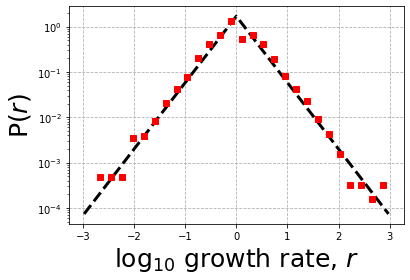

In [141]:
# Function to calculate growth rate
def log_growth_rate(x):
    T = len(x)
    r=np.zeros(T-1)
    for t in range(T-1):
        if ((x[t] != 0) & (x[t+1] != 0)):
            r[t] = np.log10(x[t+1]/x[t])
        else:
            r[t] = np.nan
    return r

# Laplace distribution function
def laplace(y, mu, b):
    return (1 / (2 * b)) * np.exp(-np.abs(y - mu) / b)

# Load data
df = pd.read_csv('/Users/rie_maskawa/Dropbox/study/whole_life_mouse/data/mouse1.over0.1.csv', index_col=0).fillna(0)/3000

data = np.array(df)
growth_data = np.zeros((data.shape[0], data.shape[1]-1))
for i in range(data.shape[0]):
    growth_data[i,:] = log_growth_rate(data[i,:])

# Remove nan
growth_data = growth_data.flatten()
growth_data = growth_data[~np.isnan(growth_data)]

# Estimate Laplace parameter mu
mu = np.median(growth_data)

# Define bins and calculate probability distribution
num_bins = 29
bins = np.linspace(-np.max(np.abs(growth_data)), np.max(np.abs(growth_data)), num_bins)
hist = pd.Series(growth_data).value_counts(bins=bins, sort=False)
hist_nonzero = hist[hist != 0]
class_values = (bins[:-1] + bins[1:]) / 2
class_fill = class_values[hist != 0]
bin_diff = np.diff(bins)
prob = (hist_nonzero / len(growth_data)) / bin_diff[hist != 0]

# Fit the data to a log-log regression
x_vals = np.concatenate([class_fill[class_fill > mu], -class_fill[class_fill < mu]])
y_vals = np.concatenate([np.log10(prob[class_fill > mu]), np.log10(prob[class_fill < mu])])
cf = np.polyfit(x_vals, y_vals, 1)
b = -(1 / cf[0]) * np.log10(math.e)

# Plot the results
fig, ax = plt.subplots()
ax.plot(bins, laplace(bins, mu, b), color='black', lw=3, label='Laplace', ls='--')
ax.plot(class_fill, prob, marker='s', linewidth=0, markersize=6, color='red')

# Set axis labels and scale
ax.set_yscale('log')
ax.set_xlabel(r'log$_{10}$ growth rate, $r$', fontsize=25)
ax.set_ylabel(r'P($r$)', fontsize=25)
ax.grid(True, ls = '--')

print(f'μ = {round(mu,2)}', f'b = {round(b, 2)}')